In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/MyDrive/files

Mounted at /content/drive/
/content/drive/MyDrive/files


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install num2words
!pip install Sastrawi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 125 kB 6.5 MB/s 
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13723 sha256=7e98bc6fc6860e06148ccfa8fd57b0b70ce3d53c471af228e68c7a89c6d7952d
  Stored in directory: /root/.cache/pip/wheels/72/b0/3f/1d95f96ff986c7dfffe46ce2be4062f38ebd04b506c77c81b9
Successfully built docopt
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 209 kB 9.1 MB/s 


Import Library

In [ ]:
import prapengolahan
import Embedding as em
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import GRU, Dense, Embedding, Dropout, Bidirectional
from tensorflow.keras.models import Sequential
from sklearn.model_selection import KFold, StratifiedKFold
from keras.callbacks import ModelCheckpoint
from matplotlib import pyplot
from tensorflow.keras.preprocessing import text, sequence
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import pickle

In [ ]:
class self_attention(layers.Layer):
    def __init__(self,**kwargs):
        super(self_attention,self).__init__(**kwargs)
        
    def build(self, input_shape):
        self.w = self.add_weight(name = 'attention_weight',
                                 shape = (input_shape[-1], input_shape[-1]),
                                 initializer = 'GlorotNormal',
                                 trainable = True)
        
        self.b = self.add_weight(name = 'attention_bias',
                                 shape = (input_shape[-1], 1),
                                 initializer = 'GlorotNormal',
                                 trainable = True)
        super(self_attention, self).build(input_shape)
        
    def call(self, input):
        step1 = tf.math.tanh(tf.matmul(input, self.w))
        step2 = tf.squeeze(tf.matmul(step1, self.b), axis=-1)
        alpha = tf.keras.activations.softmax(step2)
        att = tf.expand_dims(alpha, axis=-1)
        output = input*att
        return tf.keras.backend.sum(output, axis=1)
    
    def get_config(self):
        config = super(self_attention,self).get_config()
        return config

In [ ]:
def custom_loss(y_true, y_pred):
  mean_y_actual = tf.matmul(y_true, 
                            tf.constant([0, 0.3333333333, 0.6666666666, 1.0], 
                            shape=[4, 1]))
  mean_y_pred = tf.matmul(y_pred, 
                          tf.constant([0, 0.3333333333, 0.6666666666, 1.0], 
                          shape=[4, 1]))
  mse = tf.keras.losses.MeanSquaredError()
  return mse(mean_y_actual, mean_y_pred)

def custom_accuracy(y_true, y_pred):
  actual = tf.argmax(tf.matmul(y_true, 
                               tf.constant([1, 0, 1, 0, 0, 1, 0, 1], 
                               shape=[4, 2], dtype=tf.float32)),1 )
  pred = tf.argmax(tf.matmul(y_pred, 
                             tf.constant([1, 0, 1, 0, 0, 1, 0, 1], 
                             shape=[4, 2], dtype=tf.float32)), 1)
  correct = 0
  for i in range(len(actual)):
    if actual[i] == pred[i]:
      correct += 1
  acc = float(correct)/float(len(actual))
  return acc

In [ ]:
def create_model(vocab_len, embedding_matrix, fun_loss, acc):  
  SAN_model = Sequential()
  SAN_model.add(Embedding(vocab_len, 100, 
                          trainable = False, 
                          weights=[embedding_matrix]))
  SAN_model.add(Dropout(0.2))
  SAN_model.add(Bidirectional(GRU(64, return_sequences=True)))
  SAN_model.add(self_attention())
  SAN_model.add(Dropout(0.5))
  SAN_model.add(Dense(16, activation='relu'))
  SAN_model.add(Dense(4, activation='softmax'))
  SAN_model.compile(loss=fun_loss, 
                    optimizer='adamax', 
                    metrics=[acc])
  return SAN_model

In [ ]:
def load_data(fp):
  proses = prapengolahan.Preprocessing(fp)
  cleaning = proses.processTweet()
  newFile = proses.savepreprocess(cleaning, 'result_final_preprocessing.csv')
  proses = em.prepare_data(newFile)
  X, Y, max_len = proses.load_dataset()
  x_seq, x_pad, word_index = proses.seq_to_pad(X, max_len)
  return X, Y, max_len, x_pad, word_index

In [ ]:
def training():
  print('------------------------------------------------------------------------')
  print('Memproses Dataset')
  X, Y, max_len, x_pad, word_index = load_data('final_dataset.csv')
  print('------------------------------------------------------------------------')
  print('Dataset Selesai diproses')

  print('------------------------------------------------------------------------')
  print('Memproses Word embedding')
  embedding = em.prepare_embedding("glove_wiki_id_100.txt", word_index)
  embedding_matrix, vocab_len = embedding.embedding_matrix()
  print('------------------------------------------------------------------------')
  print('Word embedding selesai diproses\n')

  acc_per_fold = []
  loss_per_fold = []
  kfold = KFold(n_splits=10, shuffle=True)
  fold_num = 1

  for train_index,test_index in kfold.split(x_pad, Y):
    x_train,x_test = x_pad[train_index],x_pad[test_index]
    y_train,y_test = Y[train_index],Y[test_index]
    print(f'Fold:{fold_num}, Train set: {len(train_index)}, Test set:{len(test_index)}')

    model = create_model(vocab_len, embedding_matrix, custom_loss, custom_accuracy)
    checkpoint = tf.keras.callbacks.ModelCheckpoint('final_model_fold_'+str(fold_num)+'.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    callback_list = [checkpoint]

    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_num} ...')

    history = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size = 32, epochs=10, callbacks=callback_list)
    
    model.load_weights('final_model_fold_'+str(fold_num)+'.h5')
    scores = model.evaluate(x_test, y_test)
    print(f'Score for fold {fold_num}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]}')
    acc_per_fold.append(scores[1])
    loss_per_fold.append(scores[0])

    # plot loss during training
    pyplot.figure(figsize=(7, 2))
    pyplot.title('Loss '+str(fold_num)+' fold')
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='validation')
    pyplot.legend()

    # plot loss during training
    pyplot.figure(figsize=(7, 3))
    pyplot.title('Accuracy '+str(fold_num)+' fold')
    pyplot.plot(history.history['custom_accuracy'], label='train')
    pyplot.plot(history.history['val_custom_accuracy'], label='validation')
    pyplot.legend()

    fold_num += 1
  
  print('------------------------------------------------------------------------')
  print('Score per fold')
  for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}')
  print('------------------------------------------------------------------------')
  print('Average scores for all folds:')
  print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
  print(f'> Loss: {np.mean(loss_per_fold)}')
  print('------------------------------------------------------------------------')
  return X, max_len

In [ ]:
def testing(X, max_len):
  setup = prapengolahan.Preprocessing('Dataset_Testing.csv')
  cleaned_data = setup.processTweet()
  final = setup.savepreprocess(cleaned_data, 'final_testing_preprocessing.csv')
  df = pd.read_csv(final)
  x_testing = df['text'].tolist()
  y_testing = df['Label']

  tokenizer = text.Tokenizer()
  tokenizer.fit_on_texts(X)
  x_testing_seq = tokenizer.texts_to_sequences(x_testing)
  x_testing_pad = sequence.pad_sequences(x_testing_seq, maxlen=max_len)

  num = 1
  for i in range(10):
    print('--------------classification report fold '+str(num)+'---------------')
    my_model = tf.keras.models.load_model('final_model_fold_'+str(num)+'.h5', 
                                            custom_objects = {
                                                "self_attention": self_attention,
                                                "custom_loss": custom_loss,
                                                "custom_accuracy": custom_accuracy
                                            })
    prediction = my_model.predict(x_testing_pad)
    prediction_val = tf.argmax(tf.matmul(prediction, tf.constant([1, 0, 1, 0, 0, 1, 0, 1], shape=[4, 2], dtype=tf.float32)),1)
    conf_matrix = confusion_matrix(y_testing, prediction_val)

    print(conf_matrix)
    print(classification_report(y_testing, prediction_val))
    num += 1

------------------------------------------------------------------------
Memproses Dataset
memulai proses penyimpanan
Dataset hasil Preprocessing telah tersimpan
------------------------------------------------------------------------
Dataset Selesai diproses
------------------------------------------------------------------------
Memproses Word embedding
------------------------------------------------------------------------
Word embedding selesai diproses

Fold:1, Train set: 5400, Test set:600
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/10
169/169 [==============================] - ETA: 0s - loss: 0.1331 - custom_accuracy: 0.6534
Epoch 1: val_loss improved from inf to 0.10221, saving model to final_model_fold_1.h5
169/169 [==============================] - 15s 51ms/step - loss: 0.1331 - custom_accuracy: 0.6534 - val_loss: 0.1022 - val_custom_accuracy: 0.7785
Epoch 2/10
169/169 [==============================] - ETA: 0s - l

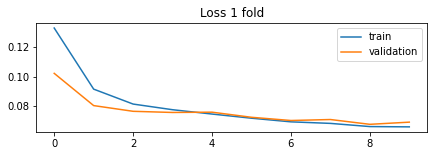

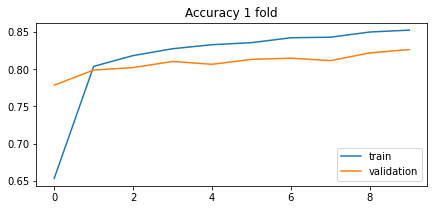

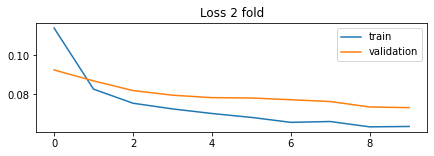

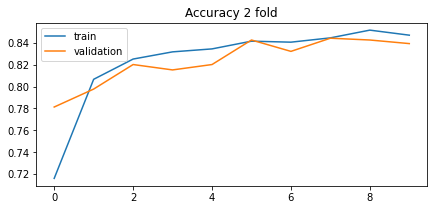

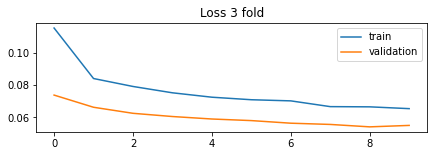

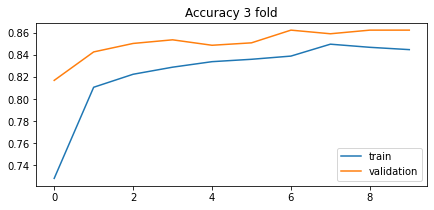

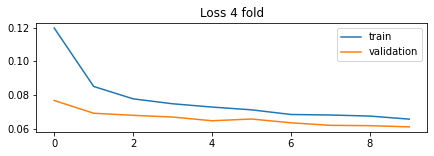

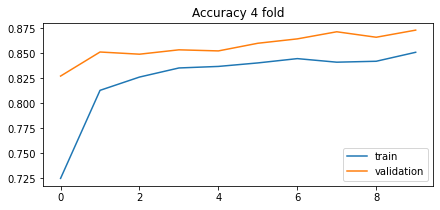

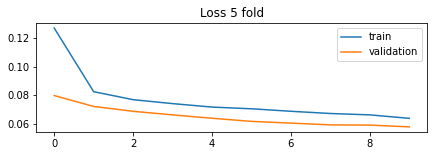

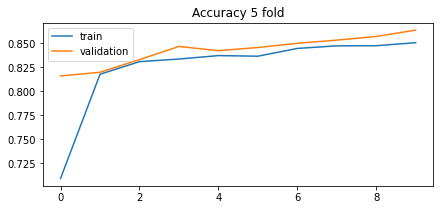

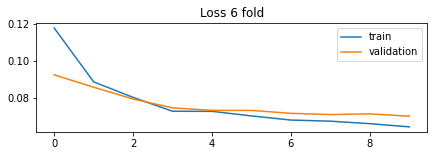

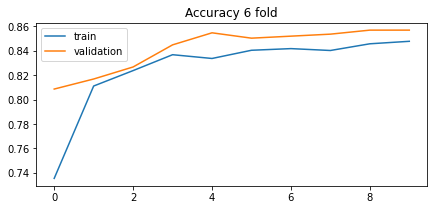

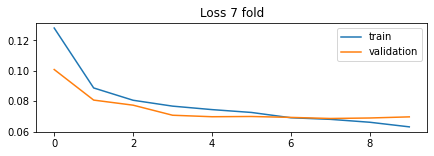

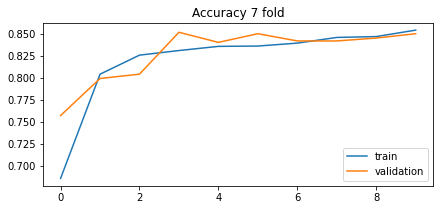

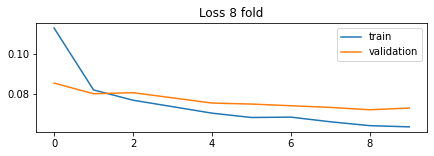

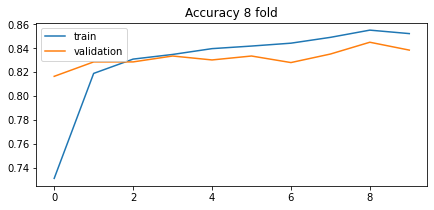

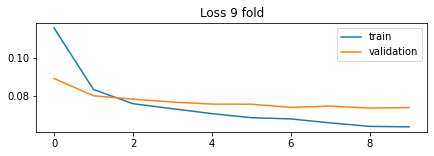

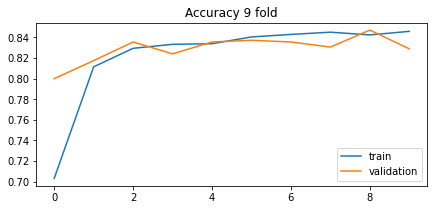

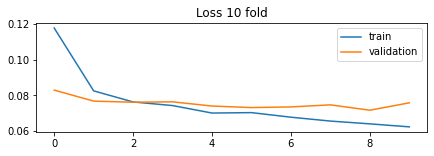

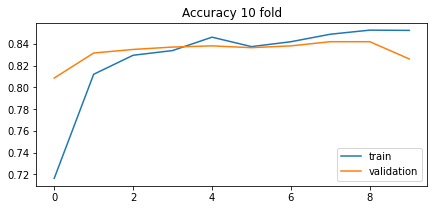

In [ ]:
X, max_len = training()

In [ ]:
testing(X, max_len)

memulai proses penyimpanan
Dataset hasil Preprocessing telah tersimpan
--------------classification report fold 1---------------
63/63 [==============================] - 3s 12ms/step
[[761 239]
 [175 825]]
              precision    recall  f1-score   support

           0       0.81      0.76      0.79      1000
           1       0.78      0.82      0.80      1000

    accuracy                           0.79      2000
   macro avg       0.79      0.79      0.79      2000
weighted avg       0.79      0.79      0.79      2000

--------------classification report fold 2---------------
63/63 [==============================] - 2s 13ms/step
[[813 187]
 [213 787]]
              precision    recall  f1-score   support

           0       0.79      0.81      0.80      1000
           1       0.81      0.79      0.80      1000

    accuracy                           0.80      2000
   macro avg       0.80      0.80      0.80      2000
weighted avg       0.80      0.80      0.80      2000

-----